In [1]:
### Configs ###
TASK = "multi_tasks"  # choose from 'pose_single', 'pose_multi', 'depth', 'multi_tasks'
MODEL = "resnet34"  # enter model name
N_EPOCHS = 128  # enter number of epochs
EARLY_STOPPING_PATIENCE = (
    16  # Stop if validation loss doesn't improve for this many epochs
)
LEARNING_RATE = 1e-4  # enter learning rate
AUGMENTATION = True
CONTINUE_TRAINING = False
MULTI_TASKS_POSE_TYPE = "multi"  # "single" or "multi"
MULTI_TASKS_REGRESSION_LOSS_WEIGHT = 8  # Weight for regression loss in multi-tasks
COLAB_DATA_MODE = "mount"  # Can be 'mount' (symlink) or 'copy'. Only used if on colab

In [2]:
### Setup if using colab ###
import os
import sys
import subprocess
import shutil  # Added import for shutil


def in_colab() -> bool:
    try:
        import google.colab  # type: ignore

        return True
    except Exception:
        return False


if in_colab():
    from google.colab import drive  # type: ignore

    print("Detected Colab. Mounting Drive...")
    drive.mount("/content/drive", force_remount=False)

    GITHUB_REPO = "https://github.com/chihuangliu/microrobot-dl.git"
    REPO_PATH = "/content/microrobot-dl"
    DRIVE_DATA_PATH = "/content/drive/MyDrive/microrobot-dl-data/data"  # where you uploaded your data on Drive

    # Clone repo if missing
    if not os.path.exists(REPO_PATH):
        print("Cloning repository...")
        subprocess.check_call(["git", "clone", GITHUB_REPO, REPO_PATH])
    else:
        print("Repository already cloned:", REPO_PATH)

    # Install package (editable) from repo root
    os.chdir(REPO_PATH)
    print("Installing package from", REPO_PATH)
    subprocess.check_call([sys.executable, "-m", "pip", "install", "uv"])
    subprocess.check_call([sys.executable, "-m", "uv", "pip", "install", "-e", "."])

    # Handle data based on COLAB_DATA_MODE
    repo_data_path = os.path.join(REPO_PATH, "data")

    # Clean up existing data path entry point first
    if os.path.exists(repo_data_path):
        if os.path.islink(repo_data_path):
            print(f"Removing existing symlink: {repo_data_path}")
            os.unlink(repo_data_path)
        elif os.path.isdir(repo_data_path):
            print(f"Removing existing directory: {repo_data_path}")
            shutil.rmtree(repo_data_path)
        else:
            print(f"Removing existing file/socket: {repo_data_path}")
            os.remove(repo_data_path)

    if not os.path.exists(DRIVE_DATA_PATH):
        print("Drive data path not found:", DRIVE_DATA_PATH)
        print(
            "Upload your data to Drive and set DRIVE_DATA_PATH accordingly. No data will be linked/copied."
        )
    else:
        if COLAB_DATA_MODE == "copy":
            print("Copying Drive data from:", DRIVE_DATA_PATH, "to", repo_data_path)
            shutil.copytree(DRIVE_DATA_PATH, repo_data_path)
            print("Data copied successfully.")
        elif COLAB_DATA_MODE == "mount":
            print(
                "Creating symlink from Drive data:",
                DRIVE_DATA_PATH,
                "to",
                repo_data_path,
            )
            os.symlink(DRIVE_DATA_PATH, repo_data_path)
            print("Data symlinked successfully.")
        else:
            print(
                f"Warning: Unknown COLAB_DATA_MODE '{COLAB_DATA_MODE}'. No data will be linked/copied."
            )

    # Change into notebooks/ so relative paths in the notebook continue to work
    notebooks_dir = os.path.join(REPO_PATH, "notebooks")
    if os.path.isdir(notebooks_dir):
        os.chdir(notebooks_dir)
        print("Changed working dir to notebooks:", os.getcwd())
    else:
        print("No notebooks/ dir found; current working dir:", os.getcwd())

    if REPO_PATH not in sys.path:
        sys.path.insert(0, REPO_PATH)
else:
    print("Not running on colab.")

Not running on colab.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from microrobot_dl.data_loader import ImageDataset2025
from microrobot_dl.testset import get_imagedataset2025_test_set
from microrobot_dl.data_loader import get_dataloaders
from microrobot_dl.model import get_model
from microrobot_dl.transform import AddGaussianNoise, TranslateTransform, ZoomTransform
from microrobot_dl.task import Task
from microrobot_dl.inference import evaluate_model, run_inference
from tqdm import tqdm
import os
import json


torch.manual_seed(60648)

# Setup device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif (
    getattr(torch.backends, "mps", None) is not None
    and torch.backends.mps.is_available()
    and torch.backends.mps.is_built()
):
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [4]:
# Load Dataset
num_outputs = 1
mode = None
multi_label = False

if TASK == Task.pose_single:
    mode = "pose"
    multi_label = False
elif TASK == Task.pose_multi:
    mode = "pose"
    multi_label = True
elif TASK == Task.depth:
    mode = "depth"
elif TASK == Task.multi_tasks:
    mode = None
    multi_label = MULTI_TASKS_POSE_TYPE == "multi"
else:
    raise ValueError(f"Task {TASK} not supported yet.")

dataset = ImageDataset2025(
    base_dir="../data/2025_Dataset",
    mode=mode,
    multi_label=multi_label,
    multi_task=(TASK == Task.multi_tasks),
    transform=None,
)

if TASK == Task.pose_multi or (TASK == Task.multi_tasks and multi_label):
    num_classes_p = len(dataset.idx_to_label_p)
    num_classes_r = len(dataset.idx_to_label_r)
    num_outputs = num_classes_p + num_classes_r
    print(f"Pose Multi: P classes={num_classes_p}, R classes={num_classes_r}")
elif TASK == Task.pose_single or (TASK == Task.multi_tasks and not multi_label):
    num_outputs = len(dataset.idx_to_label)

if TASK == Task.multi_tasks:
    num_outputs += 1  # Add depth output
    print(f"Multi Task: Pose outputs + 1 Depth output = {num_outputs}")

print(f"mode: {mode}, num_outputs: {num_outputs}")
print(f"Total samples: {len(dataset)}")

Pose Multi: P classes=18, R classes=7
Multi Task: Pose outputs + 1 Depth output = 26
mode: None, num_outputs: 26
Total samples: 2000


In [5]:
test_set_info = get_imagedataset2025_test_set()
test_indices = test_set_info["test_indices"]
test_indices = list(test_indices)
test_set = set(test_indices)

test_len = len(test_indices)
train_val_len = len(dataset) - test_len

all_indices = list(range(len(dataset)))
train_val_indices = [i for i in all_indices if i not in test_set]

test_dataset = torch.utils.data.Subset(dataset, test_indices)
train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)

transform_test = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

if AUGMENTATION:
    if TASK in [Task.pose_single, Task.pose_multi]:
        transform_train = transforms.Compose(
            [
                transforms.Resize((240, 240)),
                TranslateTransform(),
                ZoomTransform(size=(224, 224), scale=(0.8, 1.0)),
                transforms.ToTensor(),
                AddGaussianNoise(0.0, 0.02),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ]
        )
    elif TASK == Task.depth:
        transform_train = transforms.Compose(
            [
                transforms.Resize((240, 240)),
                TranslateTransform(),
                ZoomTransform(size=(224, 224), scale=(0.8, 1.0)),
                transforms.RandomRotation(degrees=15.0),
                transforms.ToTensor(),
                AddGaussianNoise(0.0, 0.01),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ]
        )
    elif TASK == Task.multi_tasks:
        transform_train = transforms.Compose(
            [
                transforms.Resize((240, 240)),
                TranslateTransform(),
                ZoomTransform(size=(224, 224), scale=(0.8, 1.0)),
                transforms.ToTensor(),
                AddGaussianNoise(0.0, 0.01),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ]
        )

else:
    transform_train = transform_test


t_train = transform_train if AUGMENTATION else transform_test
t_test = transform_test

train_loader, test_loader, val_loader = get_dataloaders(
    train_val_dataset,
    test_dataset,
    val_ratio=0.1,
    train_batch_size=32,
    test_batch_size=64,
    val_batch_size=64,
    transform_train=t_train,
    transform_test=t_test,
)

In [6]:
# Setup Model
model = get_model(MODEL, num_outputs=num_outputs, in_channels=1)

if model is None:
    raise ValueError(f"Model {MODEL} not supported.")

model = model.to(device)

# Loss and Optimizer
if TASK in [Task.pose_single, Task.pose_multi]:
    criterion = nn.CrossEntropyLoss()
elif TASK == Task.depth:
    criterion = nn.MSELoss()
elif TASK == Task.multi_tasks:
    criterion_pose = nn.CrossEntropyLoss()
    criterion_depth = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [7]:
suffix = ""
if AUGMENTATION:
    suffix += "_augmented"

if multi_label and TASK == Task.multi_tasks:
    suffix += "_multi_label"

MODEL_NAME = f"{MODEL}_{TASK}{suffix}"
MODEL_PATH = f"../model/{MODEL_NAME}.pth"
train_losses, val_losses = [], []
train_accs, val_accs = [], []  # Stores Accuracy for pose, RMSE for depth
best_val_loss = float("inf")
epochs_no_improve = 0  # Counter for early stopping


if CONTINUE_TRAINING and os.path.exists(MODEL_PATH):
    print(f"Loading checkpoint from {MODEL_PATH}...")
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    if "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    best_val_loss = checkpoint.get("val_loss", float("inf"))
    start_epoch = checkpoint.get("epoch", 0)

for epoch in range(N_EPOCHS):
    running_loss = 0.0
    running_mse = 0.0
    correct = 0
    total = 0

    for outputs, labels in tqdm(
        run_inference(model, train_loader, device, TASK, training=True),
        total=len(train_loader),
    ):
        optimizer.zero_grad()

        if TASK == Task.multi_tasks:
            pose_labels, depth_labels = labels
        else:
            # labels is already a tensor on device
            pass

        if TASK == Task.pose_multi:
            # labels: [batch, 2] (p, r)
            label_p = labels[:, 0]
            label_r = labels[:, 1]

            # Split output
            out_p = outputs[:, :num_classes_p]
            out_r = outputs[:, num_classes_p:]

            loss = criterion(out_p, label_p) + criterion(out_r, label_r)
        elif TASK == Task.multi_tasks:
            if multi_label:
                # outputs: [batch, num_p + num_r + 1]
                out_p = outputs[:, :num_classes_p]
                out_r = outputs[:, num_classes_p : num_classes_p + num_classes_r]
                out_d = outputs[:, -1:]

                label_p = pose_labels[:, 0]
                label_r = pose_labels[:, 1]

                loss_depth = criterion_depth(out_d, depth_labels)
                loss = (
                    criterion_pose(out_p, label_p)
                    + criterion_pose(out_r, label_r)
                    + loss_depth * MULTI_TASKS_REGRESSION_LOSS_WEIGHT
                )
            else:
                # outputs: [batch, num_classes + 1]
                out_pose = outputs[:, :-1]
                out_d = outputs[:, -1:]

                loss_depth = criterion_depth(out_d, depth_labels)
                loss = (
                    criterion_pose(out_pose, pose_labels)
                    + loss_depth * MULTI_TASKS_REGRESSION_LOSS_WEIGHT
                )

            running_mse += loss_depth.item() * outputs.size(0)
        else:
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * outputs.size(0)

        if TASK == Task.pose_single:
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        elif TASK == Task.pose_multi:
            out_p = outputs[:, :num_classes_p]
            out_r = outputs[:, num_classes_p:]
            _, pred_p = torch.max(out_p, 1)
            _, pred_r = torch.max(out_r, 1)
            total += labels.size(0)
            # Joint accuracy: both must be correct
            correct += (
                ((pred_p == labels[:, 0]) & (pred_r == labels[:, 1])).sum().item()
            )
        elif TASK == Task.multi_tasks:
            if multi_label:
                out_p = outputs[:, :num_classes_p]
                out_r = outputs[:, num_classes_p : num_classes_p + num_classes_r]
                _, pred_p = torch.max(out_p, 1)
                _, pred_r = torch.max(out_r, 1)
                total += pose_labels.size(0)
                correct += (
                    ((pred_p == pose_labels[:, 0]) & (pred_r == pose_labels[:, 1]))
                    .sum()
                    .item()
                )
            else:
                out_pose = outputs[:, :-1]
                _, pred = torch.max(out_pose, 1)
                total += pose_labels.size(0)
                correct += (pred == pose_labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_rmse = 0.0

    if TASK in [Task.pose_single, Task.pose_multi, Task.multi_tasks]:
        epoch_metric = correct / total
    else:
        epoch_metric = epoch_loss**0.5  # RMSE

    if TASK == Task.multi_tasks:
        epoch_rmse = (running_mse / total) ** 0.5

    train_losses.append(epoch_loss)
    train_accs.append(epoch_metric)

    # Validation phase
    val_results = evaluate_model(
        model,
        val_loader,
        device,
        TASK,
        criterion=criterion if TASK not in [Task.multi_tasks] else None,
        criterion_pose=criterion_pose if TASK == Task.multi_tasks else None,
        criterion_depth=criterion_depth if TASK == Task.multi_tasks else None,
        num_classes_p=num_classes_p if "num_classes_p" in locals() else 0,
        num_classes_r=num_classes_r if "num_classes_r" in locals() else 0,
        multi_label=multi_label,
        multi_tasks_regression_loss_weight=MULTI_TASKS_REGRESSION_LOSS_WEIGHT,
    )

    val_loss = val_results["loss"]
    val_metric = val_results.get("accuracy", val_results.get("rmse", 0.0))
    val_rmse = val_results.get("rmse", 0.0)

    val_losses.append(val_loss)
    val_accs.append(val_metric)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0  # Reset counter
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_metric": val_metric,
                "val_loss": val_loss,
            },
            MODEL_PATH,
        )
        print(f"Saved best model to {MODEL_PATH} (Val Loss: {val_loss:.4f})")
    else:
        epochs_no_improve += 1

    if TASK == Task.multi_tasks:
        print(
            f"Epoch {epoch + 1}/{N_EPOCHS} - Train Loss: {epoch_loss:.4f} Acc: {epoch_metric:.4f} RMSE: {epoch_rmse:.4f} | Val Loss: {val_loss:.4f} Acc: {val_metric:.4f} RMSE: {val_rmse:.4f}"
        )
    else:
        metric_name = "Acc" if TASK in [Task.pose_single, Task.pose_multi] else "RMSE"
        print(
            f"Epoch {epoch + 1}/{N_EPOCHS} - Train Loss: {epoch_loss:.4f} {metric_name}: {epoch_metric:.4f} | Val Loss: {val_loss:.4f} {metric_name}: {val_metric:.4f}"
        )

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(
            f"Early stopping triggered. No improvement for {EARLY_STOPPING_PATIENCE} epochs."
        )
        break

100%|██████████| 45/45 [00:11<00:00,  4.03it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 5.1918)
Epoch 1/128 - Train Loss: 4.8063 Acc: 0.0271 RMSE: 0.2691 | Val Loss: 5.1918 Acc: 0.0437 RMSE: 0.3771


100%|██████████| 45/45 [00:10<00:00,  4.24it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 3.0963)
Epoch 2/128 - Train Loss: 3.5796 Acc: 0.0910 RMSE: 0.1719 | Val Loss: 3.0963 Acc: 0.1750 RMSE: 0.1658


100%|██████████| 45/45 [00:10<00:00,  4.24it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 2.7038)
Epoch 3/128 - Train Loss: 2.9022 Acc: 0.1597 RMSE: 0.1619 | Val Loss: 2.7038 Acc: 0.1938 RMSE: 0.2079


100%|██████████| 45/45 [00:10<00:00,  4.22it/s]



Epoch 4/128 - Train Loss: 2.3436 Acc: 0.2840 RMSE: 0.1525 | Val Loss: 2.9866 Acc: 0.2562 RMSE: 0.2154


100%|██████████| 45/45 [00:10<00:00,  4.22it/s]



Epoch 5/128 - Train Loss: 2.0775 Acc: 0.3819 RMSE: 0.1725 | Val Loss: 2.7079 Acc: 0.3125 RMSE: 0.3398


100%|██████████| 45/45 [00:10<00:00,  4.23it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 1.7273)
Epoch 6/128 - Train Loss: 1.7772 Acc: 0.4854 RMSE: 0.1550 | Val Loss: 1.7273 Acc: 0.4062 RMSE: 0.1217


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 1.6636)
Epoch 7/128 - Train Loss: 1.5719 Acc: 0.5535 RMSE: 0.1468 | Val Loss: 1.6636 Acc: 0.4437 RMSE: 0.1365


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 1.6606)
Epoch 8/128 - Train Loss: 1.3369 Acc: 0.6292 RMSE: 0.1435 | Val Loss: 1.6606 Acc: 0.5000 RMSE: 0.1495


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 1.6491)
Epoch 9/128 - Train Loss: 1.2057 Acc: 0.6583 RMSE: 0.1383 | Val Loss: 1.6491 Acc: 0.4813 RMSE: 0.1498


100%|██████████| 45/45 [00:10<00:00,  4.18it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 1.0994)
Epoch 10/128 - Train Loss: 1.0435 Acc: 0.7326 RMSE: 0.1499 | Val Loss: 1.0994 Acc: 0.7438 RMSE: 0.1592


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 11/128 - Train Loss: 0.8541 Acc: 0.7646 RMSE: 0.1231 | Val Loss: 1.1023 Acc: 0.7063 RMSE: 0.1438


100%|██████████| 45/45 [00:10<00:00,  4.19it/s]



Epoch 12/128 - Train Loss: 0.7821 Acc: 0.7896 RMSE: 0.1201 | Val Loss: 1.3062 Acc: 0.6625 RMSE: 0.2240


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 13/128 - Train Loss: 0.6792 Acc: 0.8201 RMSE: 0.1132 | Val Loss: 1.1542 Acc: 0.6687 RMSE: 0.1686


100%|██████████| 45/45 [00:10<00:00,  4.22it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 0.7446)
Epoch 14/128 - Train Loss: 0.5808 Acc: 0.8493 RMSE: 0.1056 | Val Loss: 0.7446 Acc: 0.8000 RMSE: 0.1033


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 15/128 - Train Loss: 0.5878 Acc: 0.8597 RMSE: 0.1334 | Val Loss: 1.1327 Acc: 0.6438 RMSE: 0.1413


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 16/128 - Train Loss: 0.4865 Acc: 0.8799 RMSE: 0.1106 | Val Loss: 1.0946 Acc: 0.7063 RMSE: 0.1555


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 17/128 - Train Loss: 0.4683 Acc: 0.8903 RMSE: 0.1156 | Val Loss: 0.8901 Acc: 0.8000 RMSE: 0.1599


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 0.5827)
Epoch 18/128 - Train Loss: 0.4140 Acc: 0.9090 RMSE: 0.1124 | Val Loss: 0.5827 Acc: 0.8438 RMSE: 0.0983


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 19/128 - Train Loss: 0.4035 Acc: 0.9118 RMSE: 0.1113 | Val Loss: 0.7021 Acc: 0.8688 RMSE: 0.2057


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 20/128 - Train Loss: 0.3844 Acc: 0.9194 RMSE: 0.1160 | Val Loss: 0.9028 Acc: 0.7562 RMSE: 0.1557


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 0.5743)
Epoch 21/128 - Train Loss: 0.3150 Acc: 0.9431 RMSE: 0.1090 | Val Loss: 0.5743 Acc: 0.8875 RMSE: 0.1670


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 0.4212)
Epoch 22/128 - Train Loss: 0.2738 Acc: 0.9493 RMSE: 0.0942 | Val Loss: 0.4212 Acc: 0.8938 RMSE: 0.1389


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 23/128 - Train Loss: 0.2744 Acc: 0.9590 RMSE: 0.1097 | Val Loss: 0.4903 Acc: 0.8688 RMSE: 0.1272


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 0.3439)
Epoch 24/128 - Train Loss: 0.3083 Acc: 0.9278 RMSE: 0.1029 | Val Loss: 0.3439 Acc: 0.9250 RMSE: 0.1016


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 25/128 - Train Loss: 0.2773 Acc: 0.9653 RMSE: 0.1270 | Val Loss: 0.7917 Acc: 0.8625 RMSE: 0.2309


100%|██████████| 45/45 [00:10<00:00,  4.15it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 0.3431)
Epoch 26/128 - Train Loss: 0.2085 Acc: 0.9757 RMSE: 0.1018 | Val Loss: 0.3431 Acc: 0.9000 RMSE: 0.1045


100%|██████████| 45/45 [00:10<00:00,  4.22it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 0.3056)
Epoch 27/128 - Train Loss: 0.2177 Acc: 0.9646 RMSE: 0.0983 | Val Loss: 0.3056 Acc: 0.9500 RMSE: 0.1357


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 0.2160)
Epoch 28/128 - Train Loss: 0.1826 Acc: 0.9674 RMSE: 0.0872 | Val Loss: 0.2160 Acc: 0.9375 RMSE: 0.0766


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 29/128 - Train Loss: 0.1596 Acc: 0.9792 RMSE: 0.0866 | Val Loss: 0.3562 Acc: 0.9375 RMSE: 0.1447


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 30/128 - Train Loss: 0.1680 Acc: 0.9757 RMSE: 0.0894 | Val Loss: 0.3812 Acc: 0.9437 RMSE: 0.1501


100%|██████████| 45/45 [00:10<00:00,  4.19it/s]



Epoch 31/128 - Train Loss: 0.1869 Acc: 0.9729 RMSE: 0.1022 | Val Loss: 0.4992 Acc: 0.8625 RMSE: 0.1214


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 32/128 - Train Loss: 0.1782 Acc: 0.9799 RMSE: 0.0991 | Val Loss: 0.5381 Acc: 0.8187 RMSE: 0.1080


100%|██████████| 45/45 [00:10<00:00,  4.15it/s]



Epoch 33/128 - Train Loss: 0.1620 Acc: 0.9833 RMSE: 0.0990 | Val Loss: 0.4351 Acc: 0.8688 RMSE: 0.0852


100%|██████████| 45/45 [00:10<00:00,  4.19it/s]



Epoch 34/128 - Train Loss: 0.1377 Acc: 0.9819 RMSE: 0.0843 | Val Loss: 0.4827 Acc: 0.8438 RMSE: 0.0891


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 0.1566)
Epoch 35/128 - Train Loss: 0.1346 Acc: 0.9854 RMSE: 0.0920 | Val Loss: 0.1566 Acc: 1.0000 RMSE: 0.1126


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 36/128 - Train Loss: 0.1478 Acc: 0.9882 RMSE: 0.1046 | Val Loss: 0.2316 Acc: 0.9500 RMSE: 0.1066


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 37/128 - Train Loss: 0.1497 Acc: 0.9785 RMSE: 0.0941 | Val Loss: 0.2551 Acc: 0.9563 RMSE: 0.0974


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 0.0980)
Epoch 38/128 - Train Loss: 0.1237 Acc: 0.9917 RMSE: 0.0899 | Val Loss: 0.0980 Acc: 0.9938 RMSE: 0.0614


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 39/128 - Train Loss: 0.0894 Acc: 0.9979 RMSE: 0.0825 | Val Loss: 0.1357 Acc: 0.9812 RMSE: 0.0792


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 40/128 - Train Loss: 0.0988 Acc: 0.9951 RMSE: 0.0808 | Val Loss: 0.1848 Acc: 0.9500 RMSE: 0.0981


100%|██████████| 45/45 [00:10<00:00,  4.22it/s]



Epoch 41/128 - Train Loss: 0.1277 Acc: 0.9826 RMSE: 0.0895 | Val Loss: 0.5914 Acc: 0.8750 RMSE: 0.1336


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 42/128 - Train Loss: 0.1519 Acc: 0.9826 RMSE: 0.1004 | Val Loss: 0.2833 Acc: 0.9750 RMSE: 0.1501


100%|██████████| 45/45 [00:10<00:00,  4.22it/s]



Epoch 43/128 - Train Loss: 0.1037 Acc: 0.9910 RMSE: 0.0830 | Val Loss: 0.1540 Acc: 0.9875 RMSE: 0.1105


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 44/128 - Train Loss: 0.1145 Acc: 0.9840 RMSE: 0.0784 | Val Loss: 0.2956 Acc: 0.9187 RMSE: 0.0756


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 45/128 - Train Loss: 0.0912 Acc: 0.9903 RMSE: 0.0748 | Val Loss: 0.1854 Acc: 0.9563 RMSE: 0.0714


100%|██████████| 45/45 [00:10<00:00,  4.23it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 0.0889)
Epoch 46/128 - Train Loss: 0.0966 Acc: 0.9861 RMSE: 0.0634 | Val Loss: 0.0889 Acc: 0.9938 RMSE: 0.0658


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 47/128 - Train Loss: 0.1205 Acc: 0.9854 RMSE: 0.0884 | Val Loss: 0.2092 Acc: 0.9750 RMSE: 0.1294


100%|██████████| 45/45 [00:10<00:00,  4.22it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 0.0599)
Epoch 48/128 - Train Loss: 0.0811 Acc: 0.9931 RMSE: 0.0704 | Val Loss: 0.0599 Acc: 1.0000 RMSE: 0.0677


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 49/128 - Train Loss: 0.0749 Acc: 0.9965 RMSE: 0.0783 | Val Loss: 0.1033 Acc: 0.9875 RMSE: 0.0905


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 50/128 - Train Loss: 0.0751 Acc: 0.9993 RMSE: 0.0831 | Val Loss: 0.0862 Acc: 0.9875 RMSE: 0.0624


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 51/128 - Train Loss: 0.0660 Acc: 0.9993 RMSE: 0.0769 | Val Loss: 0.1158 Acc: 1.0000 RMSE: 0.1039


100%|██████████| 45/45 [00:10<00:00,  4.22it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 0.0514)
Epoch 52/128 - Train Loss: 0.0534 Acc: 1.0000 RMSE: 0.0708 | Val Loss: 0.0514 Acc: 1.0000 RMSE: 0.0680


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 53/128 - Train Loss: 0.0470 Acc: 0.9993 RMSE: 0.0654 | Val Loss: 0.0524 Acc: 1.0000 RMSE: 0.0560


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 54/128 - Train Loss: 0.0544 Acc: 0.9965 RMSE: 0.0677 | Val Loss: 0.0951 Acc: 0.9812 RMSE: 0.0463


100%|██████████| 45/45 [00:10<00:00,  4.22it/s]



Epoch 55/128 - Train Loss: 0.0673 Acc: 0.9924 RMSE: 0.0612 | Val Loss: 0.1214 Acc: 0.9688 RMSE: 0.0792


100%|██████████| 45/45 [00:10<00:00,  4.19it/s]



Epoch 56/128 - Train Loss: 0.0635 Acc: 0.9979 RMSE: 0.0726 | Val Loss: 0.0980 Acc: 0.9875 RMSE: 0.0954


100%|██████████| 45/45 [00:10<00:00,  4.22it/s]



Epoch 57/128 - Train Loss: 0.0521 Acc: 0.9993 RMSE: 0.0688 | Val Loss: 0.0966 Acc: 1.0000 RMSE: 0.1017


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 58/128 - Train Loss: 0.0518 Acc: 0.9986 RMSE: 0.0704 | Val Loss: 0.1085 Acc: 1.0000 RMSE: 0.1078


100%|██████████| 45/45 [00:10<00:00,  4.22it/s]



Epoch 59/128 - Train Loss: 0.0586 Acc: 0.9986 RMSE: 0.0725 | Val Loss: 0.1224 Acc: 0.9812 RMSE: 0.0959


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 60/128 - Train Loss: 0.0895 Acc: 0.9875 RMSE: 0.0726 | Val Loss: 0.8289 Acc: 0.8187 RMSE: 0.0940


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 61/128 - Train Loss: 0.1152 Acc: 0.9847 RMSE: 0.0754 | Val Loss: 0.2376 Acc: 0.9375 RMSE: 0.0900


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 62/128 - Train Loss: 0.1126 Acc: 0.9875 RMSE: 0.0876 | Val Loss: 0.1337 Acc: 0.9750 RMSE: 0.0744


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 63/128 - Train Loss: 0.1374 Acc: 0.9771 RMSE: 0.0815 | Val Loss: 2.5526 Acc: 0.4437 RMSE: 0.1276


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 64/128 - Train Loss: 0.1670 Acc: 0.9646 RMSE: 0.0867 | Val Loss: 0.2134 Acc: 0.9437 RMSE: 0.0793


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 65/128 - Train Loss: 0.0986 Acc: 0.9854 RMSE: 0.0766 | Val Loss: 0.4577 Acc: 0.9375 RMSE: 0.1853


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 66/128 - Train Loss: 0.0720 Acc: 0.9944 RMSE: 0.0678 | Val Loss: 0.1552 Acc: 0.9563 RMSE: 0.0817


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 67/128 - Train Loss: 0.0570 Acc: 0.9979 RMSE: 0.0683 | Val Loss: 0.0531 Acc: 0.9938 RMSE: 0.0546


100%|██████████| 45/45 [00:10<00:00,  4.22it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 0.0365)
Epoch 68/128 - Train Loss: 0.0498 Acc: 0.9979 RMSE: 0.0610 | Val Loss: 0.0365 Acc: 1.0000 RMSE: 0.0570


100%|██████████| 45/45 [00:10<00:00,  4.19it/s]



Epoch 69/128 - Train Loss: 0.0624 Acc: 0.9951 RMSE: 0.0717 | Val Loss: 0.0377 Acc: 1.0000 RMSE: 0.0554


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 70/128 - Train Loss: 0.0539 Acc: 0.9972 RMSE: 0.0660 | Val Loss: 0.1283 Acc: 0.9875 RMSE: 0.0984


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 71/128 - Train Loss: 0.0927 Acc: 0.9924 RMSE: 0.0646 | Val Loss: 0.6138 Acc: 0.8187 RMSE: 0.0695


100%|██████████| 45/45 [00:10<00:00,  4.19it/s]



Epoch 72/128 - Train Loss: 0.0806 Acc: 0.9910 RMSE: 0.0744 | Val Loss: 0.2101 Acc: 0.9250 RMSE: 0.0666


100%|██████████| 45/45 [00:10<00:00,  4.22it/s]



Epoch 73/128 - Train Loss: 0.0742 Acc: 0.9896 RMSE: 0.0636 | Val Loss: 0.0916 Acc: 1.0000 RMSE: 0.0881


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 74/128 - Train Loss: 0.0552 Acc: 0.9972 RMSE: 0.0686 | Val Loss: 0.0508 Acc: 1.0000 RMSE: 0.0702


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 75/128 - Train Loss: 0.0431 Acc: 1.0000 RMSE: 0.0646 | Val Loss: 0.0524 Acc: 0.9938 RMSE: 0.0693


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 76/128 - Train Loss: 0.0388 Acc: 1.0000 RMSE: 0.0622 | Val Loss: 0.0576 Acc: 1.0000 RMSE: 0.0773


100%|██████████| 45/45 [00:10<00:00,  4.22it/s]



Epoch 77/128 - Train Loss: 0.0374 Acc: 1.0000 RMSE: 0.0620 | Val Loss: 0.0516 Acc: 0.9938 RMSE: 0.0677


100%|██████████| 45/45 [00:10<00:00,  4.15it/s]



Saved best model to ../model/resnet34_multi_tasks_augmented_multi_label.pth (Val Loss: 0.0314)
Epoch 78/128 - Train Loss: 0.0338 Acc: 1.0000 RMSE: 0.0589 | Val Loss: 0.0314 Acc: 1.0000 RMSE: 0.0560


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 79/128 - Train Loss: 0.0398 Acc: 1.0000 RMSE: 0.0651 | Val Loss: 0.0326 Acc: 1.0000 RMSE: 0.0578


100%|██████████| 45/45 [00:10<00:00,  4.15it/s]



Epoch 80/128 - Train Loss: 0.0336 Acc: 0.9979 RMSE: 0.0548 | Val Loss: 0.0523 Acc: 1.0000 RMSE: 0.0656


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 81/128 - Train Loss: 0.0975 Acc: 0.9819 RMSE: 0.0621 | Val Loss: 0.7954 Acc: 0.8562 RMSE: 0.1473


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 82/128 - Train Loss: 0.1181 Acc: 0.9806 RMSE: 0.0772 | Val Loss: 0.1403 Acc: 0.9500 RMSE: 0.0800


100%|██████████| 45/45 [00:10<00:00,  4.20it/s]



Epoch 83/128 - Train Loss: 0.0699 Acc: 0.9938 RMSE: 0.0713 | Val Loss: 0.0732 Acc: 0.9875 RMSE: 0.0656


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 84/128 - Train Loss: 0.0502 Acc: 0.9965 RMSE: 0.0645 | Val Loss: 0.0955 Acc: 0.9750 RMSE: 0.0486


100%|██████████| 45/45 [00:10<00:00,  4.21it/s]



Epoch 85/128 - Train Loss: 0.0591 Acc: 0.9944 RMSE: 0.0633 | Val Loss: 0.1208 Acc: 1.0000 RMSE: 0.1128


100%|██████████| 45/45 [00:10<00:00,  4.22it/s]



Epoch 86/128 - Train Loss: 0.0453 Acc: 0.9951 RMSE: 0.0590 | Val Loss: 0.0989 Acc: 0.9938 RMSE: 0.0918


100%|██████████| 45/45 [00:10<00:00,  4.15it/s]



Epoch 87/128 - Train Loss: 0.0551 Acc: 0.9972 RMSE: 0.0660 | Val Loss: 0.0830 Acc: 0.9812 RMSE: 0.0685


100%|██████████| 45/45 [03:46<00:00,  5.04s/it]



Epoch 88/128 - Train Loss: 0.0798 Acc: 0.9882 RMSE: 0.0696 | Val Loss: 0.1487 Acc: 0.9688 RMSE: 0.0855


100%|██████████| 45/45 [04:31<00:00,  6.03s/it]



Epoch 89/128 - Train Loss: 0.0731 Acc: 0.9896 RMSE: 0.0679 | Val Loss: 0.1536 Acc: 0.9688 RMSE: 0.1062


100%|██████████| 45/45 [01:05<00:00,  1.45s/it]



Epoch 90/128 - Train Loss: 0.1267 Acc: 0.9743 RMSE: 0.0713 | Val Loss: 0.1907 Acc: 0.9875 RMSE: 0.1123


100%|██████████| 45/45 [08:12<00:00, 10.94s/it]  



Epoch 91/128 - Train Loss: 0.0957 Acc: 0.9889 RMSE: 0.0774 | Val Loss: 0.1526 Acc: 0.9812 RMSE: 0.1055


100%|██████████| 45/45 [04:51<00:00,  6.48s/it]



Epoch 92/128 - Train Loss: 0.0643 Acc: 0.9931 RMSE: 0.0681 | Val Loss: 0.0413 Acc: 1.0000 RMSE: 0.0647


100%|██████████| 45/45 [09:21<00:00, 12.48s/it]



Epoch 93/128 - Train Loss: 0.0416 Acc: 0.9993 RMSE: 0.0639 | Val Loss: 0.0404 Acc: 0.9938 RMSE: 0.0610


100%|██████████| 45/45 [04:27<00:00,  5.93s/it]



Epoch 94/128 - Train Loss: 0.0307 Acc: 1.0000 RMSE: 0.0564 | Val Loss: 0.0356 Acc: 1.0000 RMSE: 0.0620
Early stopping triggered. No improvement for 16 epochs.


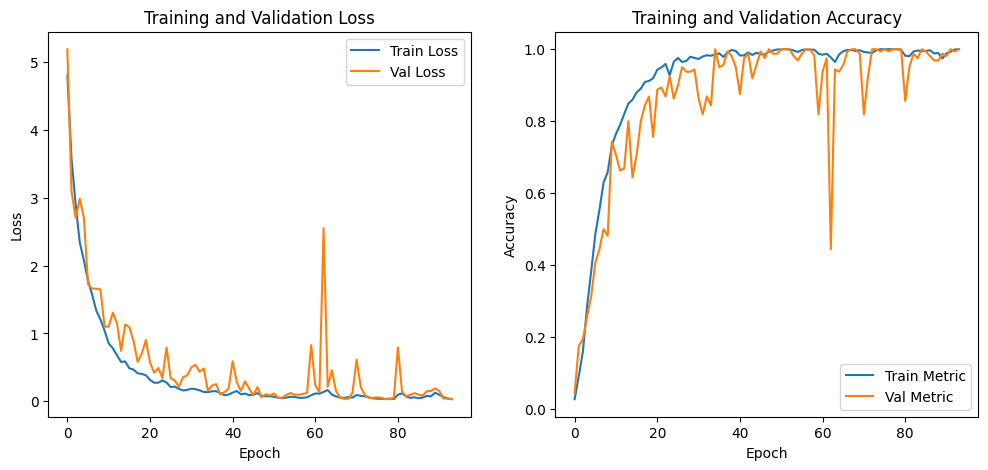

In [8]:
# Plot Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Metric")
plt.plot(val_accs, label="Val Metric")
plt.xlabel("Epoch")
plt.ylabel(
    "Accuracy"
    if TASK in [Task.pose_single, Task.pose_multi, Task.multi_tasks]
    else "RMSE"
)
plt.legend()
plt.title(
    f"Training and Validation {'Accuracy' if TASK in [Task.pose_single, Task.pose_multi, Task.multi_tasks] else 'RMSE'}"
)

plt.show()

In [9]:
# Test Evaluation
# Load best checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
if "optimizer_state_dict" in checkpoint:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

epoch_loaded = checkpoint.get("epoch")
val_metric_loaded = checkpoint.get("val_metric")
val_loss_loaded = checkpoint.get("val_loss")
print(
    f"Loaded checkpoint from {MODEL_PATH} (epoch={epoch_loaded}, val_metric={val_metric_loaded}, val_loss={val_loss_loaded})"
)

test_results = evaluate_model(
    model,
    test_loader,
    device,
    TASK,
    criterion=criterion if TASK not in [Task.multi_tasks] else None,
    criterion_pose=criterion_pose if TASK == Task.multi_tasks else None,
    criterion_depth=criterion_depth if TASK == Task.multi_tasks else None,
    num_classes_p=num_classes_p if "num_classes_p" in locals() else 0,
    num_classes_r=num_classes_r if "num_classes_r" in locals() else 0,
    multi_label=multi_label,
    multi_tasks_regression_loss_weight=MULTI_TASKS_REGRESSION_LOSS_WEIGHT,
)

test_metric = test_results.get("accuracy", test_results.get("rmse", 0.0))
test_rmse = test_results.get("rmse", 0.0)
accuracy_p = test_results.get("accuracy_p", 0.0)
accuracy_r = test_results.get("accuracy_r", 0.0)

if TASK in [Task.pose_single, Task.pose_multi, Task.multi_tasks]:
    print(f"Test Set Accuracy: {test_metric:.4f}")
    if TASK == Task.pose_multi:
        print(f"Test Set P Accuracy: {accuracy_p:.4f}")
        print(f"Test Set R Accuracy: {accuracy_r:.4f}")
    if TASK == Task.multi_tasks:
        print(f"Test Set RMSE: {test_rmse:.4f}")
        if multi_label:
            print(f"Test Set P Accuracy: {accuracy_p:.4f}")
            print(f"Test Set R Accuracy: {accuracy_r:.4f}")
else:
    print(f"Test Set RMSE: {test_metric:.4f}")

Loaded checkpoint from ../model/resnet34_multi_tasks_augmented_multi_label.pth (epoch=78, val_metric=1.0, val_loss=0.031414665281772614)
Test Set Accuracy: 0.9900
Test Set RMSE: 0.0650
Test Set P Accuracy: 0.9900
Test Set R Accuracy: 1.0000
Test Set Accuracy: 0.9900
Test Set RMSE: 0.0650
Test Set P Accuracy: 0.9900
Test Set R Accuracy: 1.0000


In [ ]:
results = {
    "model_name": MODEL_NAME,
    "metric_name": "accuracy"
    if TASK in [Task.pose_single, Task.pose_multi, Task.multi_tasks]
    else "rmse",
    "metric_value": test_metric,
    "metadata": {
        "N_EPOCHS": N_EPOCHS + start_epoch if CONTINUE_TRAINING else N_EPOCHS,
        "EARLY_STOPPING_PATIENCE": EARLY_STOPPING_PATIENCE,
        "augmentation": AUGMENTATION,
        "learning_rate": LEARNING_RATE,
        "multi_label": multi_label,
        "multi_tasks_regression_loss_weight": MULTI_TASKS_REGRESSION_LOSS_WEIGHT,
    },
}

if TASK == Task.pose_single or (TASK == Task.multi_tasks and not multi_label):
    results["metadata"]["precision"] = test_results.get("precision", 0.0)
    results["metadata"]["recall"] = test_results.get("recall", 0.0)
    results["metadata"]["f1"] = test_results.get("f1", 0.0)

if TASK == Task.pose_multi or (TASK == Task.multi_tasks and multi_label):
    results["metadata"]["accuracy_p"] = accuracy_p
    results["metadata"]["accuracy_r"] = accuracy_r
    results["metadata"]["precision_p"] = test_results.get("precision_p", 0.0)
    results["metadata"]["recall_p"] = test_results.get("recall_p", 0.0)
    results["metadata"]["f1_p"] = test_results.get("f1_p", 0.0)
    results["metadata"]["precision_r"] = test_results.get("precision_r", 0.0)
    results["metadata"]["recall_r"] = test_results.get("recall_r", 0.0)
    results["metadata"]["f1_r"] = test_results.get("f1_r", 0.0)

if TASK == Task.multi_tasks:
    results["metadata"]["rmse"] = test_rmse

out_dir = f"../eval/{TASK}"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

out_path = os.path.join(out_dir, f"{MODEL_NAME}.json")

if os.path.exists(out_path):
    try:
        with open(out_path, "r") as f:
            existing = json.load(f)
    except Exception:
        existing = None

    if isinstance(existing, list):
        existing.append(results)
        data_to_write = existing
    elif isinstance(existing, dict):
        data_to_write = [existing, results]
    else:
        data_to_write = [results]
else:
    data_to_write = [results]

with open(out_path, "w") as f:
    json.dump(data_to_write, f, indent=2)

print(f"Saved results to {out_path}")

Saved results to ../eval/multi_tasks/resnet34_multi_tasks_augmented_multi_label.json
